<a href="https://colab.research.google.com/github/tjwei/GAN_Tutorial/blob/master/ACGAN_intro_for_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
tf.enable_eager_execution()

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time
from skimage.io import imshow

from IPython.display import display

In [0]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()


In [3]:
train_images.dtype, train_images.shape

(dtype('uint8'), (50000, 32, 32, 3))

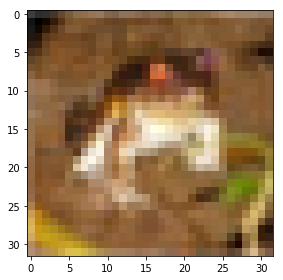

In [4]:
imshow(train_images[0])

In [0]:
def img_to_float(img):
  return (np.float32(img)-127.5)/127.5
def img_to_uint8(img):
  return np.uint8(img*127.5+128).clip(0, 255)

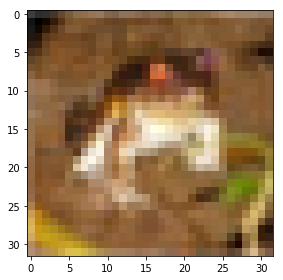

In [6]:
train_img_f32 = img_to_float(train_images)
imshow(img_to_uint8(train_img_f32[0]))

In [0]:
BUFFER_SIZE = train_img_f32.shape[0]
BATCH_SIZE = 25
train_dataset_y = tf.data.Dataset.from_tensor_slices(train_labels[:, 0]).map(lambda y: tf.one_hot(y, 10))
train_dataset_x = tf.data.Dataset.from_tensor_slices(train_img_f32)
train_dataset = tf.data.Dataset.zip((train_dataset_x, train_dataset_y)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [0]:
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape
from tensorflow.keras.layers import  Conv2DTranspose, Input, concatenate, Conv2D
from tensorflow.keras import Model
latent_dim = 100

_0 = Input((latent_dim,))
_1 = Input((10,))
_ = concatenate([_0, _1])
_ = Dense(4*4*256, use_bias=False, input_shape=(latent_dim,))(_)
_ = BatchNormalization()(_)
_ = LeakyReLU()(_)
_ = Reshape((4, 4, 256))(_)
_ = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False)(_)
_ = BatchNormalization()(_)
_ = LeakyReLU()(_)
_ = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False)(_)
_ = BatchNormalization()(_)
_ = LeakyReLU()(_)
_ = Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same', use_bias=False)(_)
_ = BatchNormalization()(_)
_ = LeakyReLU()(_)
_ = Conv2D(3, (3, 3), strides=(1, 1), padding='same', activation='tanh')(_)
generator = Model(inputs=[_0,_1], outputs=_)

In [0]:
from tensorflow.keras.layers import Conv2D, Dropout, Flatten
_i = Input((32,32, 3))
_ = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(_i)
_ = LeakyReLU()(_)
_ = Conv2D(128, (3, 3), strides=(2, 2), padding='same', use_bias=False)(_)
_ = BatchNormalization()(_)
_ = LeakyReLU()(_)
_ = Conv2D(128, (3, 3), strides=(2, 2), padding='same', use_bias=False)(_)
_ = BatchNormalization()(_)
_ = LeakyReLU()(_)
_ = Conv2D(128, (3, 3), strides=(2, 2), padding='same', use_bias=False)(_)
_ = BatchNormalization()(_)
_ = LeakyReLU()(_)
_ = Flatten()(_)
_0 = Dense(1)(_)
_1 = Dense(10)(_)

discriminator = Model(inputs=_i, outputs=[_0, _1])

In [0]:
def generator_loss(generated_output, labels):
  out_d, out_c = generated_output
  loss_d = tf.losses.sigmoid_cross_entropy(tf.ones_like(out_d), out_d)
  loss_c = tf.losses.softmax_cross_entropy(labels, out_c)
  return loss_d+loss_c

In [0]:
def discriminator_loss(real_output, generated_output, labels):
    # [1,1,...,1] with real output since it is true and we want our generated examples to look like it
    real_out_d, real_out_c = real_output
    real_loss_d = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.ones_like(real_out_d), logits=real_out_d)
    real_loss_c = tf.losses.softmax_cross_entropy(labels, real_out_c)
    real_loss = real_loss_d + real_loss_c

    # [0,0,...,0] with generated images since they are fake
    generated_out_d, generated_out_c = generated_output
    generated_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.zeros_like(generated_out_d), logits=generated_out_d)
    total_loss = real_loss + generated_loss

    return total_loss

In [0]:
generator_optimizer = tf.train.AdamOptimizer(1e-4)
discriminator_optimizer = tf.train.AdamOptimizer(1e-4)

In [0]:
EPOCHS = 50
num_examples_to_generate = 20

# We'll re-use this random vector used to seed the generator so
# it will be easier to see the improvement over time.
random_vector_for_generation = tf.random_normal([num_examples_to_generate,
                                                 latent_dim])
condition_vector_generation = tf.one_hot(list(range(10))+list(range(10)), 10)

In [0]:
def train_step(images, labels):
   # generating noise from a normal distribution
      noise = tf.random_normal([BATCH_SIZE, latent_dim])
      
      with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images= generator([noise, labels], training=True)
        real_output = discriminator(images, training=True)
        generated_output = discriminator(generated_images, training=True)
         
        gen_loss = generator_loss(generated_output, labels)
        disc_loss = discriminator_loss(real_output, generated_output, labels)
        
      gradients_of_generator = gen_tape.gradient(gen_loss, generator.variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.variables)
      
      generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.variables))
      discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.variables))

In [15]:
train_step = tf.contrib.eager.defun(train_step)

W0828 04:47:05.159970 139777925511040 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



W0828 04:47:07.588575 139777925511040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/autograph/converters/directives.py:117: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0828 04:47:08.076944 139777925511040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/autograph/converters/directives.py:117: The name tf.losses.sigmoid_cross_entropy is deprecated. Please use tf.compat.v1.losses.sigmoid_cross_entropy instead.

W0828 04:47:08.078456 139777925511040 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/autograph/converters/directives.py:117: The name tf.losses.softmax_cross_entropy is deprecated. Please use tf.compat.v1.losses.softmax_cross_entropy instead.

W0828 04:47:08.140935 139777925511040 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (

0 50.13113594055176


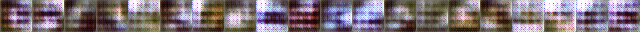

1 47.19972276687622


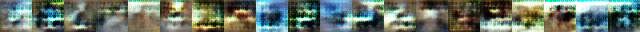

2 47.22281312942505


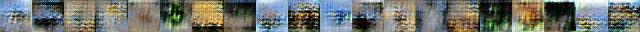

3 47.14704871177673


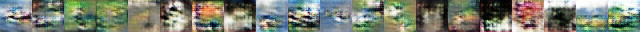

4 47.052210092544556


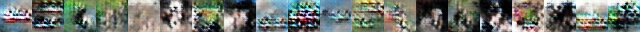

5 47.26092338562012


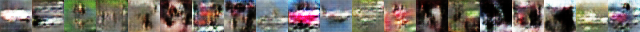

6 47.2059280872345


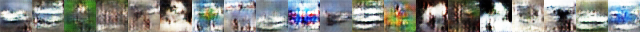

7 47.19394016265869


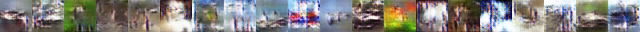

8 47.28057360649109


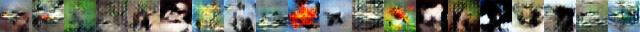

9 47.20043110847473


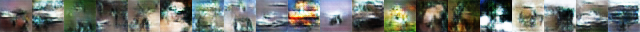

10 47.17023539543152


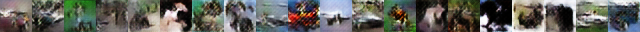

11 47.174440145492554


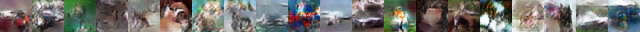

12 46.870784521102905


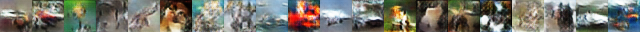

13 47.09675168991089


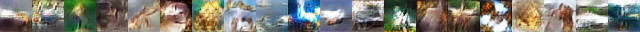

14 46.979713678359985


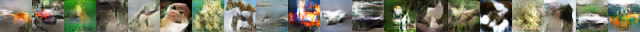

In [16]:
for epoch in range(15):
  start_time = time.time()
  for images, labels in train_dataset:
      train_step(images, labels)
  fake = generator([random_vector_for_generation, condition_vector_generation], training=False)
  fake_concat = np.transpose(img_to_uint8(fake), [1,0,2,3]).reshape((32,-1,3))
  print(epoch, time.time()-start_time)
  display(PIL.Image.fromarray(fake_concat))
  
  

0 47.61849236488342


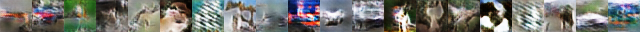

In [0]:
for epoch in range(15):
  start_time = time.time()
  for images, labels in train_dataset:
      train_step(images, labels)
  fake = generator([random_vector_for_generation, condition_vector_generation], training=False)
  fake_concat = np.transpose(img_to_uint8(fake), [1,0,2,3]).reshape((32,-1,3))
  print(epoch, time.time()-start_time)
  display(PIL.Image.fromarray(fake_concat))
  
  